In [28]:
sys.path.append("..")
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
colors = sns.color_palette("Set1")
sns.set_style('ticks')


In [29]:
def get_paths(relative_dir = "results/09jun/"):
    paths = os.listdir("../" + relative_dir)
    rel_paths = []
    for i in range(len(paths)):
        if not (paths[i] == '.DS_Store' or paths[i] == 'archive'):
            rel_paths.append(relative_dir + paths[i])
    return rel_paths

## Plot vaccinated distribution for all results

Read results

In [30]:
def find_policy_name(path):
    string = path.split("_")[2]
    if string == 'susceptible':
        return "Population-Based"
    if string == 'infection':
        return "Infection-Based"
    if string == 'random':
        return "Random"
    if string == 'oldest':
        return "Age-Based"
    if string == 'contact':
        return "Contact-Based"
    if string == 'fhi':
        return "NIPH"
    if string == 'no':
        return "No Vaccines"
    return "Weighted"

In [31]:

paths = get_paths()
results = {}
counter=1
for relative_path in paths:
    key = find_policy_name(relative_path)
    if key=="Weighted":
        if counter > 1:
            continue
        key += f"_{counter}"
        counter += 1
    results[key] = utils.read_csv(relative_path=relative_path)

100%|██████████| 500/500 [00:07<00:00, 62.91it/s]


In [32]:
print(results.keys())

(age_labels_infection, vaccines_available_infection, flow_scale_infection, contact_weights_infection, S_regions_infection, I_regions_infection, new_infected_regions_infection, new_deaths_regions_infection, vaccinated_regions_infection, S_age_groups_infection, I_age_groups_infection, new_infected_age_groups_infection, new_deaths_age_groups_infection, vaccinated_age_groups_infection, dates_infection) = results["Infection-Based"]
(age_labels, vaccines_available, flow_scale, contact_weights, S_regions, I_regions, new_infected_regions, new_deaths_regions, vaccinated_regions, S_age_groups, I_age_groups, new_infected_age_groups, new_deaths_age_groups, vaccinated_age_groups, dates) = results["Age-Based"]

dict_keys(['Contact-Based', 'Infection-Based', 'NIPH', 'Population-Based', 'Age-Based', 'No Vaccines', 'Random'])


In [33]:
shape = I_regions.shape
nr_simulations = shape[0]
nr_weeks = shape[1]
nr_regions = shape[2]

#for i in range(nr_simulations):
    #print(f"simulation {i}: {np.max(np.mean(np.cumsum(new_infected_regions[:,:,:],axis=0)[-1,:],axis) - np.cumsum(new_infected_regions_infection[:,:,:],axis=0)[-1,:])}")

In [34]:
"""
array = np.sum(np.cumsum(new_infected_regions[:,:,:],axis=1)[:,-1,:], axis=1) - np.sum(np.cumsum(new_infected_regions_infection[:,:,:],axis=1)[:,-1,:],axis=1)
n=5

idx = np.argpartition(array, -n)[-n:]

indices_biggest_diff = idx[np.argsort((-array)[idx])]
"""

'\narray = np.sum(np.cumsum(new_infected_regions[:,:,:],axis=1)[:,-1,:], axis=1) - np.sum(np.cumsum(new_infected_regions_infection[:,:,:],axis=1)[:,-1,:],axis=1)\nn=5\n\nidx = np.argpartition(array, -n)[-n:]\n\nindices_biggest_diff = idx[np.argsort((-array)[idx])]\n'

In [35]:
"""
n=2
numbers = np. array([1, 3, 2, 4])
idx = np. argpartition(numbers, -n)[-n:]
indices = idx[np. argsort((-numbers)[idx])]
indices
"""

'\nn=2\nnumbers = np. array([1, 3, 2, 4])\nidx = np. argpartition(numbers, -n)[-n:]\nindices = idx[np. argsort((-numbers)[idx])]\nindices\n'

In [36]:
"""
infection = np.sum(np.cumsum(new_infected_regions_infection[:,:,:],axis=1)[:,:,:],axis=2)
oldest_first = np.sum(np.cumsum(new_infected_regions[:,:,:],axis=1)[:,:,:], axis=2)
for i in range(len(indices)):
    plt.figure()
    sns.barplot(np.arange(nr_weeks),infection[i,:], color=colors[i])
    plt.show()
    plt.figure()
    sns.barplot(np.arange(nr_weeks), oldest_first[i,:], color=colors[i])
    plt.show()
    print();print();print();print()
    
"""

'\ninfection = np.sum(np.cumsum(new_infected_regions_infection[:,:,:],axis=1)[:,:,:],axis=2)\noldest_first = np.sum(np.cumsum(new_infected_regions[:,:,:],axis=1)[:,:,:], axis=2)\nfor i in range(len(indices)):\n    plt.figure()\n    sns.barplot(np.arange(nr_weeks),infection[i,:], color=colors[i])\n    plt.show()\n    plt.figure()\n    sns.barplot(np.arange(nr_weeks), oldest_first[i,:], color=colors[i])\n    plt.show()\n    print();print();print();print()\n    \n'

In [37]:
"""
n=5
inf_array = np.cumsum(new_infected_regions_infection[70,:,:],axis=0)[-1,:]
array = np.cumsum(new_infected_regions[70,:,:],axis=0)[-1,:]

idx_infection = np.argpartition(inf_array, -n)[-n:]
idx = np.argpartition(array, -n)[-n:]

indices_infection = idx_infection[np.argsort((-inf_array)[idx_infection])]
indices = idx[np.argsort((-array)[idx])]

for i in range(len(indices)):
    plt.figure()
    sns.lineplot(np.arange(nr_weeks),new_infected_regions_infection[70,:,indices[i]], color=colors[i])
    plt.show()
    plt.figure()
    sns.lineplot(np.arange(nr_weeks), new_infected_regions[70,:,indices[i]], color=colors[i])
    plt.show()
    print();print();print();print()
    
"""


'\nn=5\ninf_array = np.cumsum(new_infected_regions_infection[70,:,:],axis=0)[-1,:]\narray = np.cumsum(new_infected_regions[70,:,:],axis=0)[-1,:]\n\nidx_infection = np.argpartition(inf_array, -n)[-n:]\nidx = np.argpartition(array, -n)[-n:]\n\nindices_infection = idx_infection[np.argsort((-inf_array)[idx_infection])]\nindices = idx[np.argsort((-array)[idx])]\n\nfor i in range(len(indices)):\n    plt.figure()\n    sns.lineplot(np.arange(nr_weeks),new_infected_regions_infection[70,:,indices[i]], color=colors[i])\n    plt.show()\n    plt.figure()\n    sns.lineplot(np.arange(nr_weeks), new_infected_regions[70,:,indices[i]], color=colors[i])\n    plt.show()\n    print();print();print();print()\n    \n'

In [38]:
 def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 432x288 with 0 Axes>

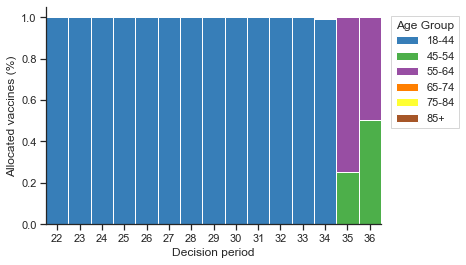

<Figure size 432x288 with 0 Axes>

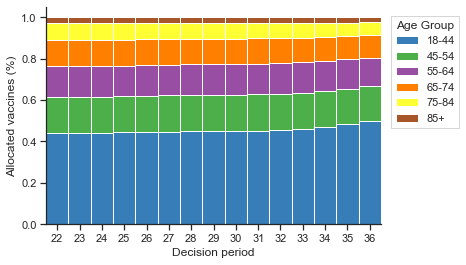

<Figure size 432x288 with 0 Axes>

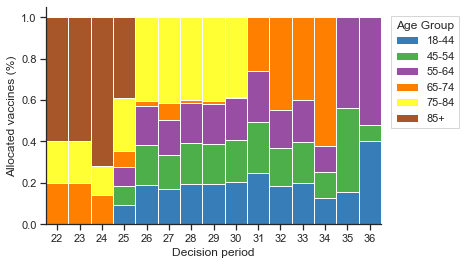

<Figure size 432x288 with 0 Axes>

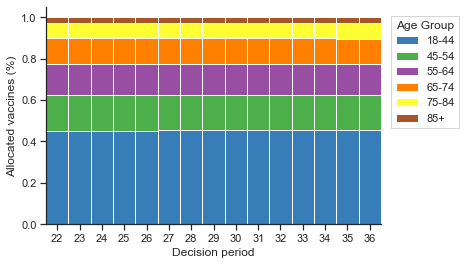

<Figure size 432x288 with 0 Axes>

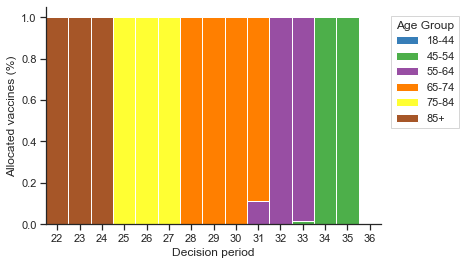

<Figure size 432x288 with 0 Axes>

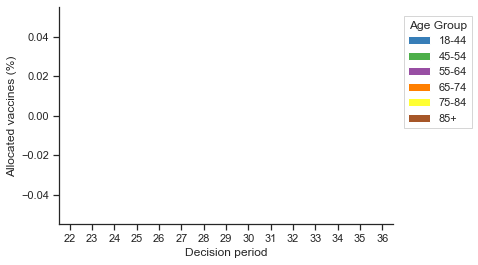

<Figure size 432x288 with 0 Axes>

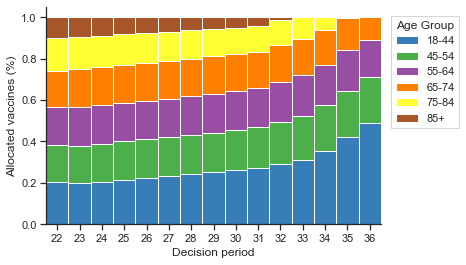

In [39]:
paths = get_paths()
keys = list(results.keys())

for i in range(len(keys)):
    age_labels = results[keys[i]][0]
    vaccinated_age_groups = results[keys[i]][-2]
    vaccinated_age_groups = np.diff(vaccinated_age_groups, axis=1)
    vaccinated_mean = vaccinated_age_groups.mean(axis=0)
    week_cut = 22 #Where vaccines are available
    norm = np.where(np.int64(vaccinated_mean.sum(axis=1, keepdims=True))==0, 1, vaccinated_mean.sum(axis=1, keepdims=True))
    vaccinated_mean[week_cut:].sum(axis=1)
    vaccinated_proportions = np.divide(vaccinated_mean, norm)
    vaccinated_proportions[week_cut:].sum(axis=1)
    vaccinated_cumsum = vaccinated_mean.cumsum(axis=1)
    weeks = np.arange(vaccinated_proportions.shape[0])
    df = pd.DataFrame(columns=age_labels[1:], data=vaccinated_proportions[week_cut:,1:], index=weeks[week_cut:])
    plt.figure()
    ax = df.plot(kind='bar', stacked=True, color=colors[1:],)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    change_width(ax, 1)
    lgd = plt.legend(title="Age Group",loc='right', bbox_to_anchor=(1.25, 0.7), ncol=1, fancybox=False)
    plt.xticks(rotation=0)
    plt.xlabel("Decision period")
    plt.ylabel("Allocated vaccines (%)")
    plt.savefig(f"../plots/vaccination/{keys[i]}_vaccination_by_age.png", dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

## Analysis of simulations needed

In [40]:
nr_sim = results[list(results.keys())[0]][4].shape[0]
objective_values = {}
for keys in results.keys():
    objective_values[keys] = np.zeros((nr_sim,5)) #axis 1: index 0: deaths, 1: infected, 2: yll, 3: vaccinated, 4: weighted


In [348]:
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', "../" + paths.config)

for key in list(results.keys()):
    print("Finding objective values for ", key)
    result = results[key]
    age_labels = result[0]
    
    new_deaths_age_groups = result[-3]
    cumulative_deaths = new_deaths_age_groups.cumsum(axis=1)
    cum_deaths = np.zeros((cumulative_deaths.shape[0], cumulative_deaths.shape[2]))
    yll = np.zeros((cumulative_deaths.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        cum_deaths[i] = cumulative_deaths[i,-1,:]
        yll[i] = utils.calculate_yll(utils.get_expected_yll(config.age_bins, age_labels),  cum_deaths[i]) 
    deaths = np.sum(cum_deaths, axis=1)

    new_infected_age_groups = result[-4]
    cumulative_infected = new_infected_age_groups.cumsum(axis=1)
    infected = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_infected.shape[0]):
        infected[i] = np.sum(cumulative_infected[i,-1,:])

    vaccinated_age_groups = result[-2]
    vaccinated = np.zeros((vaccinated_age_groups.shape[0]))
    for i in range(vaccinated_age_groups.shape[0]):
        vaccinated[i] = np.sum(vaccinated_age_groups[i,-1,:])

    weighted = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        weighted[i] = 0.01*infected[i] + deaths[i]
        

    objective_values[key][:,0] = deaths
    objective_values[key][:,1] = infected
    objective_values[key][:,2] = yll
    objective_values[key][:,3] = vaccinated
    objective_values[key][:,4] = weighted

Finding objective values for  Contact-Based
Finding objective values for  Infection-Based
Finding objective values for  NIPH
Finding objective values for  Population-Based
Finding objective values for  Age-Based
Finding objective values for  No Vaccines
Finding objective values for  Random


In [349]:
def density_plot(values, key, color):
    # Draw the density plot
    ax = sns.distplot(values, hist=False, kde=True,
                 kde_kws={'linewidth': 0.8},
                 label=key, color=color)
    ax.set(yticklabels=[])
    ax.set(xlabel=None, ylabel=None)
    mean = np.mean(values)
    ax.vlines(mean, 0, ymax = ax.lines[-1].get_ydata().max()*0.9725, color=color, ls='-', lw=0.8)
    return ax

Deaths

Infected

YLL

Weighted



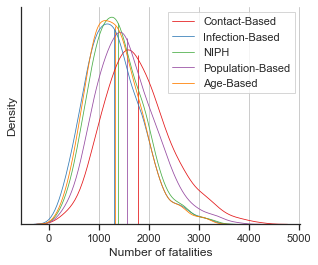

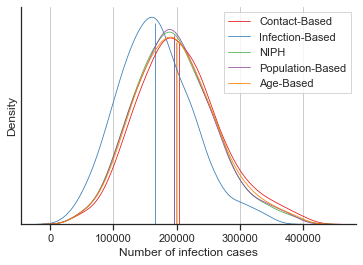

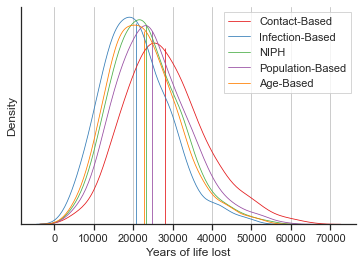

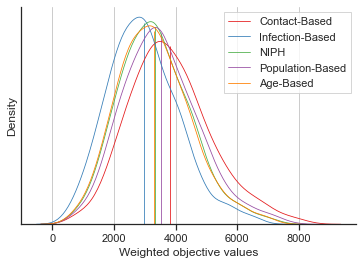

In [428]:
keys = list(results.keys())
if "Weighted_1" in keys: keys.remove("Weighted_1")
if "No Vaccines" in keys: keys.remove("No Vaccines")
if "Random" in keys: keys.remove("Random")
sns.set_style('ticks')
print("Deaths")
print()
plt.figure(figsize=(5,4))
for n in range(len(keys)):
    ax = density_plot(objective_values[keys[n]][:,0], keys[n], 'k' if keys[n]=="No Vaccines" else colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.yaxis.set_ticks([])
ax.xaxis.grid()
plt.savefig("../plots/computational_study/fatalities_distributions.png", dpi=200)

print("Infected")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,1], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of infection cases')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax.yaxis.set_ticks([])
ax.xaxis.grid()
plt.savefig("../plots/computational_study/infected_distributions.png", dpi=200)


print("YLL")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,2], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Years of life lost')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax.yaxis.set_ticks([])
ax.xaxis.grid()
plt.savefig("../plots/computational_study/yll_distributions.png", dpi=200)

print("Weighted")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,4], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Weighted objective values')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax.yaxis.set_ticks([])
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_distributions.png", dpi=200)



## T-test of observations

In [92]:
def t_test(first, second):
        """ Performs one-sided t-test to check to variables for significant difference

        Args:
            first (Individual): presumed best individual
            second (Individual): presumed worse individual
            significance (float, optional): level of significance to test against. Defaults to 0.1.

        Returns:
            bool: True if significance is achieved
        """
        if not (first==second).all():
            z = first - second
            return scipy.stats.ttest_ind(z, np.zeros(len(first)), alternative="less").pvalue
        return 1

In [400]:
dead = dict(map(lambda x: (x[0], np.array(x[1])[:,0]), objective_values.items()))
infected = dict(map(lambda x: (x[0], np.array(x[1])[:,1]), objective_values.items()))
yll = dict(map(lambda x: (x[0], np.array(x[1])[:,2]), objective_values.items()))
vaccinated = dict(map(lambda x: (x[0], np.array(x[1])[:,3]), objective_values.items()))
weighted = dict(map(lambda x: (x[0], np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1]), objective_values.items()))

mean_dead = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0])), objective_values.items()))
mean_infected = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,1])), objective_values.items()))
mean_yll = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,2])), objective_values.items()))
mean_vaccinated = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,3])), objective_values.items()))
mean_weighted = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))

sorted_dead = dict(sorted(mean_dead.items(), key=lambda x: x[1]))
sorted_infected = dict(sorted(mean_infected.items(), key=lambda x: x[1]))
sorted_yll = dict(sorted(mean_yll.items(), key=lambda x: x[1]))
sorted_vaccinated = dict(sorted(mean_vaccinated.items(), key=lambda x: x[1]))
sorted_weighted = dict(sorted(mean_weighted.items(), key=lambda x: x[1]))
 
std_dead = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0])), objective_values.items()))
std_infected = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,1])), objective_values.items()))
std_yll = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,2])), objective_values.items()))
std_vaccinated = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,3])), objective_values.items()))
std_weighted = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))


In [270]:
key= "Infection-Based"
key2= "Age-Based"
difference = dead[key] - dead[key2]
np.sum(difference<0)

402

In [268]:
dead[key].shape

(500,)

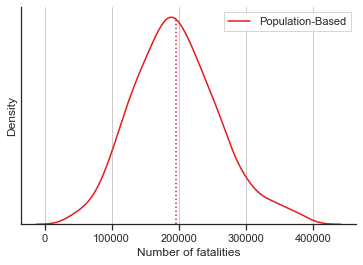

In [94]:
def density_plot(values, key, color):
    # Draw the density plot
    ax = sns.distplot(values, hist=False, kde=True,
                 kde_kws={'linewidth': 1.5},
                 label=key, color=color)
    ax.set(yticklabels=[])
    ax.set(xlabel=None, ylabel=None)
    ax.vlines(mean, 0, ymax = ax.lines[0].get_ydata().max(), color='crimson', ls=':')
    return ax

keys = ["Population-Based"]
sns.set_style('ticks')
n=0
std = np.std(objective_values[keys[n]][:,1])
mean = np.mean(objective_values[keys[n]][:,1])
print()
plt.figure()
for n in range(len(keys)):
    ax = density_plot(objective_values[keys[n]][:,1], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax.yaxis.set_ticks([])
ax.xaxis.grid()
plt.show()


## Key figures of Infection-Based vs Age-based

In [303]:
key = "Infection-Based"
key2 = "Age-Based"
key3 = "Contact-Based"

dead_infection = dead[key]
dead_age = dead[key2]
print(np.sum(dead_age < dead_infection))
print(np.mean(dead_age-dead_infection))
print(np.std(dead_age-dead_infection))


98
23.088108434236723
38.4533326488318


In [304]:
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', "../"+paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)

In [305]:
def shift5(arr, num, fill_value=-1):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [306]:
def find_consecutive(arr):
    best = 1
    counter = 1
    for k in range(1,len(arr)):
        if arr[k-1] == arr[k]-1:
            counter+=1
            if counter > best:
                best=counter
        else:
            counter=1
    return best

In [307]:
icases = results[key][6]
icases2 = results[key2][6]
diffs = np.diff(icases, prepend=0, axis=1)[:,22:,:]
diffs2 = np.diff(icases2, prepend=0, axis=1)[:,22:,:]

consecutives = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)
number_downs = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)
ends_zero = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)
ends_lowest = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)
consecutives2 = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)
number_downs2 = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)
ends_zero2 = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)
ends_lowest2 = [] #np.zeros((diffs.shape[0],diffs.shape[2]),dtype=np.int64)

for i in range(icases.shape[0]):
    consecutives.append([])
    number_downs.append([])
    ends_zero.append([])
    ends_lowest.append([])
    consecutives2.append([])
    number_downs2.append([])
    ends_zero2.append([])
    ends_lowest2.append([])
    for j in range(icases.shape[2]):
        nr_case = icases[i,:,j]
        nr_case2 = icases2[i,:,j]
        if not np.all(nr_case < 1):
            arr = np.where(diffs[i,:,j]<0)[0]
            c = find_consecutive(arr)
            consecutives[i].append(c)
            number_downs[i].append(len(arr))
            ends_zero[i].append(int(int(nr_case[-1]) < 1))
            ends_lowest[i].append(int(nr_case[-1] < nr_case2[-1]))
        
        if not np.all(nr_case2 < 1):
            arr2 = np.where(diffs2[i,:,j]<0)[0]
            c2 = find_consecutive(arr2)
            consecutives2[i].append(c2)
            number_downs2[i].append(len(arr2))
            ends_zero2[i].append(int(int(nr_case2[-1]) < 1))
            ends_lowest2[i].append(int(nr_case2[-1] < nr_case[-1]))


In [308]:

for i in range(icases.shape[0]):
    consecutives[i] = np.asarray(consecutives[i], dtype=np.int64)
    number_downs[i] = np.asarray(number_downs[i], dtype=np.int64)
    ends_zero[i] = np.asarray(ends_zero[i], dtype=np.int64)
    ends_lowest[i] = np.asarray(ends_lowest[i], dtype=np.int64)
    consecutives2[i] = np.asarray(consecutives2[i], dtype=np.int64)
    number_downs2[i] = np.asarray(number_downs2[i], dtype=np.int64)
    ends_zero2[i] = np.asarray(ends_zero2[i], dtype=np.int64)
    ends_lowest2[i] = np.asarray(ends_lowest2[i], dtype=np.int64)


In [309]:
vaccination_with_no_infections = []
vaccination_with_no_infections2 = []
for i in range(icases.shape[0]):
    nr_infection_free = len(consecutives[i])
    nr_infection_free2 = len(consecutives2[i])
    print(len(consecutives2[i]))
    consecutives[i] = np.mean(consecutives[i])
    number_downs[i] = np.mean(number_downs[i])
    ends_zero[i] = np.sum(ends_zero[i])/len(ends_zero[i])
    ends_lowest[i] = np.sum(ends_lowest[i])/len(ends_lowest[i])
    consecutives2[i] = np.mean(consecutives2[i])
    number_downs2[i] = np.mean(number_downs2[i])
    ends_zero2[i] = np.sum(ends_zero2[i])/len(ends_zero2[i])
    ends_lowest2[i] = np.sum(ends_lowest2[i])/len(ends_lowest2[i])
    vaccination_with_no_infections.append(356-nr_infection_free)
    vaccination_with_no_infections2.append(356-nr_infection_free2)

176
124
141
138
79
129
92
122
137
81
103
153
97
158
119
58
95
81
99
90
154
121
87
118
170
149
93
116
94
87
108
101
100
118
57
126
108
65
96
152
125
120
111
118
100
90
125
83
83
112
156
96
132
117
120
107
85
123
139
100
143
112
98
107
128
136
104
113
162
120
141
103
100
89
80
132
140
88
86
151
99
83
104
87
79
138
169
81
125
111
62
123
133
125
151
133
49
189
165
82
96
193
108
153
144
86
88
173
134
62
80
72
80
59
81
107
142
84
70
42
69
148
71
95
94
128
66
79
72
105
108
67
78
77
118
140
70
187
156
134
128
94
93
61
142
98
141
122
82
84
46
81
133
43
142
61
100
114
117
114
101
74
121
74
111
105
74
107
141
165
87
138
100
98
84
100
96
102
168
96
117
97
82
69
108
80
127
117
147
118
115
65
103
156
113
53
132
61
108
109
64
113
118
99
71
103
131
117
94
79
134
102
74
132
79
90
122
46
119
72
101
108
139
120
136
43
138
85
96
75
116
87
140
94
116
113
68
134
101
183
87
113
79
95
117
129
126
98
67
76
124
99
124
131
165
95
75
147
108
125
128
91
114
102
77
142
176
109
125
91
134
144
70
82
67
132
109
101
11

In [336]:
print(np.mean(consecutives))
print(np.mean(number_downs))
print(np.mean(ends_zero))
print(np.mean(ends_lowest))
print(np.mean(np.asarray(vaccination_with_no_infections)))
print()
print(np.mean(consecutives2))
print(np.mean(number_downs2))
print(np.mean(ends_zero2))
print(np.mean(ends_lowest2))
print(np.mean(np.asarray(vaccination_with_no_infections2)))

7.576722769338372
9.89726809308012
0.3727657729657948
0.7162978322368307
258.476

5.71127547750565
8.252375155311249
0.18513185765813595
0.0702820305711673
247.666


In [341]:
region = 49
vacc_sum = results[key][8][98,-1,region]
vacc_sum2 = np.sum(results[key2][8][98,-1,region])
print(vacc_sum,vacc_sum2)

0.0 3985.579705906816


In [342]:
np.sum(results[key][8][98,-1,121])

13083.99999999999

In [343]:
pop_size = population.loc[region].population
print(pop_size)
vacc_sum/pop_size

13310


0.0

In [344]:
vacc_sum2/pop_size

0.2994425023220748

In [111]:
icases.shape

(38, 356)

In [112]:
key = "Infection-Based"
key2 = "Age-Based"
region = 25

icases = results[key][6][np.argsort(-infected[key])[],:,:]
icases2 = results[key2][6][np.argsort(-infected[key])[2],:,:]
diffs = np.diff(icases, prepend=0, axis=0)[22:,:]
diffs2 = np.diff(icases2, prepend=0, axis=0)[22:,:]

print()
print("Infected down mean", f"{np.mean(diffs[diffs<0],axis=0):>15.2f}")
print("     Age down mean", f"{np.mean(diffs2[diffs2<0],axis=0):>15.2f}")

np.all(diffs[(np.where(diffs>0)[0]+22)[-1]:,:]<=0, axis=0)

print()
print("Infected mean", f"{np.mean(icases):>15.2f}")
print("     Age mean", f"{np.mean(icases2):>15.2f}")


Infected down mean          -15.92
     Age down mean          -16.30

Infected mean           24.88
     Age mean           28.88


In [331]:
def find_infected_ylim(r, max_infected):
    if r == 49:
        return 211
    if r == 113:
        return 211
    if r == 142:
        return 211
    if r == 110:
        return 211
    return max_infected + max_infected/6

def find_infected_yticks(r, max_infected):
    if r==49:
        return np.arange(211, step=30)
    if r==113:
        return np.arange(211, step=30)
    if r==142:
        return np.arange(211, step=30)
    if r==110:
        return np.arange(211, step=30)
    return np.arange(max_infected + max_infected/6, step=(max_infected/6))

def find_vaccine_ylim(r, max_infected):
    if r == 49:
        return 1501
    if r == 113:
        return 1501
    if r == 142:
        return 1501
    if r == 110:
        return 2601
    return max_vaccine+ max_vaccine/6

def find_vaccine_yticks(r, max_infected):
    if r==49:
        return np.arange(1501, step=250)
    if r==113:
        return np.arange(1501, step=250)
    if r==142:
        return np.arange(1501, step=250)
    if r==110:
        return np.arange(2601, step=325)
    return np.arange(max_vaccine + max_vaccine/6, step=max_vaccine/6)

In [399]:
infected[key]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [403]:
key = "Infection-Based"
key2 = "Age-Based"
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', "../"+paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)
# Se hvor mange økninger hver region opplever
# Se hvor mange økninger etter uke 22 hver region opplever
# Se hvor mange økninger etter uke 22 hele landet opplever

regions = [49, 113, 110, 142]

for r in regions:
    vaccine_infection = np.diff(results[key][8][np.argsort(-infected[key])[11],:,r], prepend=0)
    vaccine_other = np.diff(results[key2][8][np.argsort(-infected[key])[11],:,r], prepend=0)
    max_vaccine = np.max([np.max(vaccine_other),np.max(vaccine_infection)])

    infected_infection = results[key][6][np.argsort(-infected[key])[11],:,r]
    infected_other = results[key2][6][np.argsort(-infected[key])[11],:,r]
    max_infected = np.max([np.max(infected_infection), np.max(infected_other), 1])

    region_name = population.loc[r].region_name[:1].upper() + population.loc[r].region_name[1:].lower()
    pop_size = population.loc[r].population
    p1 = mpatches.Patch(color=colors[1], label='Vaccines given')
    p2 = mlines.Line2D([], [], color='red', marker='o', markersize=6, label='New infected')

    fig, ax1 = plt.subplots(1,figsize=(5,4))
    sns.barplot(np.arange(18), vaccine_infection[-18:], ax=ax1, color=colors[1])
    ax1.set_ylabel("Number of vaccines given")
    ax1.set_yticks(find_vaccine_yticks(r, max_infected))
    ax1.set_ylim(bottom=0, top=find_vaccine_ylim(r, max_infected))
    ax1.spines['top'].set_visible(False)
    ax1.set_xlabel("Decision period")
    ax1_2 = ax1.twinx()
    ax1_2.spines['top'].set_visible(False)
    sns.scatterplot(np.arange(18), infected_infection[-18:], ax=ax1_2, color='red', size=1, edgecolor='red')
    sns.lineplot(np.arange(18), infected_infection[-18:], ax=ax1_2, color='red', lw=0.8)
    ax1_2.set_yticks(find_infected_yticks(r, max_infected))
    ax1_2.set_ylim(bottom=0, top=find_infected_ylim(r,max_infected))
    ax1_2.set_ylabel("Number of new infected")
    plt.xticks(ticks = np.arange(18), labels =[f"{i}" for i in range(20,38)])
    ax1.xaxis.grid()
    plt.legend(handles=[p1, p2], loc="upper left")
    fig.savefig(f"../plots/regional_infection_vaccination/zoomed/{key} region {region_name}({r}).png", bbox_inches='tight')
    plt.close()

    fig, ax1 = plt.subplots(1,figsize=(5,4))
    sns.barplot(np.arange(18), vaccine_other[-18:], ax=ax1, color=colors[1])
    ax1.set_ylabel("Number of vaccines given")
    ax1.set_yticks(find_vaccine_yticks(r, max_infected))
    ax1.set_ylim(bottom=0, top=find_vaccine_ylim(r, max_infected))
    ax1.spines['top'].set_visible(False)
    ax1.set_xlabel("Decision period")
    ax1_2 = ax1.twinx()
    ax1_2.spines['top'].set_visible(False)
    sns.scatterplot(np.arange(18), infected_other[-18:], ax=ax1_2, color='red', size=1, edgecolor='red')
    sns.lineplot(np.arange(18), infected_other[-18:], ax=ax1_2, color='red', lw=0.8)
    ax1_2.set_yticks(find_infected_yticks(r, max_infected))
    ax1_2.set_ylim(bottom=0, top=find_infected_ylim(r,max_infected))
    ax1_2.set_ylabel("Number of new infected")
    plt.xticks(ticks = np.arange(18), labels =[f"{i}" for i in range(20,38)])
    ax1.xaxis.grid()
    plt.legend(handles=[p1, p2], loc="upper left")
    fig.savefig(f"../plots/regional_infection_vaccination/zoomed/{key2} region {region_name}({r}).png", bbox_inches='tight')
    plt.close()

In [277]:
#region combined
key = "Infection-Based"
key2 = "Age-Based"
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', "../"+paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)
for r in np.arange(nr_regions)[:]:
    vaccine_infection = np.diff(results[key][8][np.argsort(-infected[key])[11],:,r], prepend=0)
    vaccine_other = np.diff(results[key2][8][np.argsort(-infected[key])[11],:,r], prepend=0)
    max_vaccine = np.max([np.max(vaccine_other),np.max(vaccine_infection)])

    infected_infection = results[key][6][np.argsort(-infected[key])[11],:,r]
    infected_other = results[key2][6][np.argsort(-infected[key])[11],:,r]
    max_infected = np.max([np.max(infected_infection), np.max(infected_other), 1])

    region_name = population.loc[r].region_name[:1].upper() + population.loc[r].region_name[1:].lower()
    pop_size = population.loc[r].population
    p1 = mpatches.Patch(color=colors[1], label='Vaccines')
    p2 = mlines.Line2D([], [], color='red', marker='o', markersize=6, label='Infected')

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5*5,5))
    
    ax1 = axs[0]
    sns.barplot(np.arange(nr_weeks), vaccine_infection, ax=ax1, color=colors[1])
    ax1.set_title(key + f" in {region_name}, population size: {pop_size}")
    ax1.set_ylabel("Number of vaccines given")
    ax1.set_yticks(np.arange(max_vaccine + max_vaccine/6, step=max_vaccine/6))
    ax1.set_ylim(bottom=0, top=max_vaccine+ max_vaccine/6)
    ax1.set_xticks(np.arange(nr_weeks, step=4))
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.grid()
    ax1_2 = ax1.twinx()
    ax1_2.spines['top'].set_visible(False)
    sns.scatterplot(np.arange(nr_weeks), infected_infection, ax=ax1_2, color='red', size=1, edgecolor='red')
    sns.lineplot(np.arange(nr_weeks), infected_infection, ax=ax1_2, color='red',lw=0.8)
    ax1_2.set_yticks(np.arange(max_infected + max_infected/6, step=(max_infected/6)))
    ax1_2.set_ylim(bottom=0, top=max_infected + max_infected/6)
    plt.legend(handles=[p1, p2], loc="upper left")

    ax2 = axs[1]
    sns.barplot(np.arange(nr_weeks), vaccine_other, ax=ax2, color=colors[1])
    ax2.set_title(key2 + f" in {region_name}, population size: {pop_size}")
    ax2.set_yticks(np.arange(max_vaccine + max_vaccine/6, step=max_vaccine/6))
    ax2.set_ylim(bottom=0, top=max_vaccine+ max_vaccine/6)
    ax2.set_xticks(np.arange(nr_weeks, step=4))
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.grid()
    ax2_2 = ax2.twinx()
    ax2_2.spines['top'].set_visible(False)
    sns.scatterplot(np.arange(nr_weeks), infected_other, ax=ax2_2, color='red', size=1, edgecolor='red')
    sns.lineplot(np.arange(nr_weeks), infected_other, ax=ax2_2, color='red', lw=0.8)
    ax2_2.set_yticks(np.arange(max_infected + max_infected/6, step=(max_infected/6)))
    ax2_2.set_ylim(bottom=0, top=max_infected + max_infected/6)
    ax2_2.set_ylabel("Number of new infected")
    plt.legend(handles=[p1, p2], loc="upper left")
    fig.savefig(f"../plots/regional_infection_vaccination/ region {r}.png")
    plt.close()

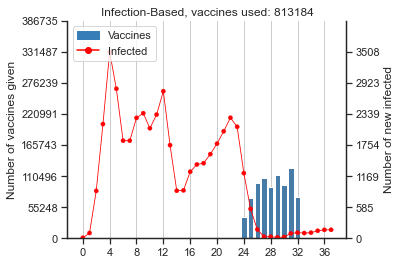

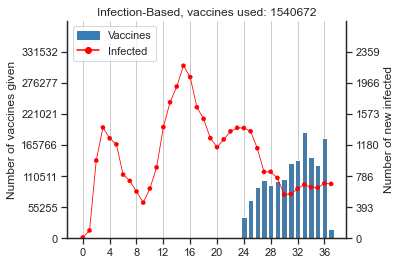

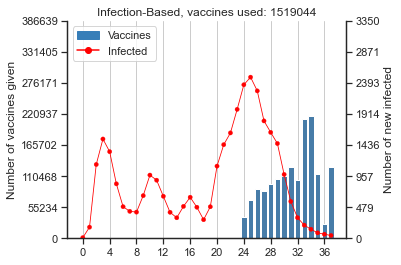

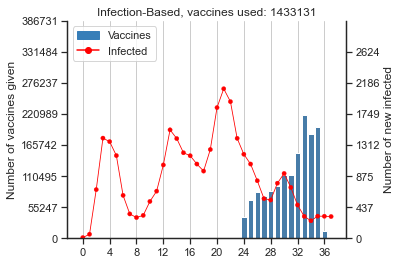

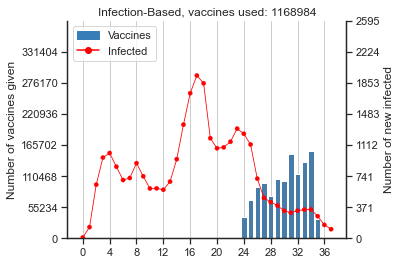

In [427]:
key = "Infection-Based"
key2 = "Age-Based"
simulations = np.argsort(-infected[key])
sims = np.concatenate((simulations[:10], simulations[-10:]))
for s in sims[-5:]:
    vaccine_infection = np.diff(np.sum(results[key][8][s,:,:], axis=1), prepend=0)
    vaccine_other = np.diff(np.sum(results[key2][8][s,:,:], axis=1), prepend=0)
    max_vaccine = np.max([np.max(vaccine_other),np.max(vaccine_infection)])

    infected_infection = np.sum(results[key][6][s,:,:], axis=1)
    infected_other = np.sum(results[key2][6][s,:,:], axis=1)
    max_infected = np.max([np.max(infected_infection), np.max(infected_other), 1])

    p1 = mpatches.Patch(color=colors[1], label='Vaccines')
    p2 = mlines.Line2D([], [], color='red', marker='o', markersize=6, label='Infected')

    fig, axs = plt.subplots(figsize=(5,4), sharex=True)
    
    ax1 = axs
    sns.barplot(np.arange(nr_weeks), vaccine_infection, ax=ax1, color=colors[1])
    ax1.set_title(key + f", vaccines used: {int(np.sum(vaccine_infection))}")
    ax1.set_ylabel("Number of vaccines given")
    ax1.set_yticks(np.arange(max_vaccine + max_vaccine/6, step=max_vaccine/6))
    ax1.set_ylim(bottom=0, top=max_vaccine+ max_vaccine/6)
    ax1.set_xticks(np.arange(nr_weeks, step=4))
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.grid()
    ax1_2 = ax1.twinx()
    ax1_2.set_ylabel("Number of new infected")
    ax1_2.spines['top'].set_visible(False)
    sns.scatterplot(np.arange(nr_weeks), infected_infection, ax=ax1_2, color='red', size=1, edgecolor='red')
    sns.lineplot(np.arange(nr_weeks), infected_infection, ax=ax1_2, color='red',lw=0.8)
    ax1_2.set_yticks(np.arange(max_infected + max_infected/6, step=(max_infected/6)))
    ax1_2.set_ylim(bottom=0, top=max_infected + max_infected/6)
    plt.legend(handles=[p1, p2], loc="upper left")
    plt.show()
    fig.savefig(f"../plots/domestic_infection_vaccination/simulation {s}.png", dpi=200)

    fig, axs = plt.subplots(figsize=(5,4), sharex=True)
    ax2 = axs
    sns.barplot(np.arange(nr_weeks), vaccine_other, ax=ax2, color=colors[1])
    ax2.set_title(key2 + f", Vaccines used: {int(np.sum(vaccine_other))}")
    ax2.set_yticks(np.arange(max_vaccine + max_vaccine/6, step=max_vaccine/6))
    ax2.set_ylim(bottom=0, top=max_vaccine+ max_vaccine/6)
    ax2.set_xticks(np.arange(nr_weeks, step=4))
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.grid()
    ax2_2 = ax2.twinx()
    ax2_2.spines['top'].set_visible(False)
    sns.scatterplot(np.arange(nr_weeks), infected_other, ax=ax2_2, color='red', size=1, edgecolor='red')
    sns.lineplot(np.arange(nr_weeks), infected_other, ax=ax2_2, color='red', lw=0.8)
    ax2_2.set_yticks(np.arange(max_infected + max_infected/6, step=(max_infected/6)))
    ax2_2.set_ylim(bottom=0, top=max_infected + max_infected/6)
    ax2_2.set_ylabel("Number of new infected")
    plt.legend(handles=[p1, p2], loc="upper left")
    plt.suptitle(f"Simulation nr {s}")
    
    plt.close()

In [24]:
new_deaths_age_groups = results["Infection-Based"][-5]
vaccinated_age_groups = results["Infection-Based"][-2]
vaccinated_country = np.sum(np.diff(vaccinated_age_groups, axis=1), axis=2)
new_deaths_country = np.sum(new_deaths_age_groups, axis=2)
print(np.where(vaccinated_country[:,22:] < 1)[0])

for index in np.unique(np.where(vaccinated_country[:,22:] < 1)[0]):
    print()
    print(np.where(vaccinated_country[index,22:] <1))
    print(new_deaths_country[index,22:])


[ 15  17  96  96  96 114 119 119 120 120 126 126 126 126 126 132 132 132
 132 132 143 150 150 150 150 150 183 183 183 183 183 183 183 200 212 217
 217 217 217 225 225 225 225 225 274 274 274 314 326 349 388 388 388 409
 409 409 409 409 424 424 424 478]

(array([14]),)
[571.6982652  505.10057953 367.2453393  279.7997159  222.50577586
 186.61552031 149.82029314 103.29058386  54.20878719  61.55153177
  61.52132579  69.24106867  78.21446103  50.6545415   33.66814113
  17.34531782]

(array([14]),)
[605.10228956 704.58729948 735.13674156 525.7471031  386.02059403
 259.7257912  163.95992796 123.04154817 101.30032803  96.46692391
 122.11800488 168.45750116 131.3013206   92.39128596  54.68639232
  30.51446565]

(array([12, 13, 14]),)
[318.65222251 356.66391587 358.34660284 358.09275968 420.48733839
 321.58424959 184.5938057  119.42708787  71.09682534  44.04043275
  29.66935173  24.75592384  26.65232858  32.03178281  19.80815053
   6.81141113]

(array([14]),)
[379.08861701 547.4171521  464.56186

In [25]:
print(np.min(np.where(vaccinated_country[183,22:]<1)))
np.sum(new_deaths_age_groups[183,22:],axis=1)

8


array([1.24444277e+02, 1.80546145e+02, 1.94969065e+02, 1.38911601e+02,
       1.05518270e+02, 8.96582791e+01, 6.17711709e+01, 3.77382317e+01,
       3.25514053e+01, 3.12515578e+01, 3.30470241e+01, 2.30982696e+01,
       1.16800954e+01, 4.18298359e+00, 6.79986336e-01, 4.65068979e-02])

Text(0, 0.5, 'Years of life lost')

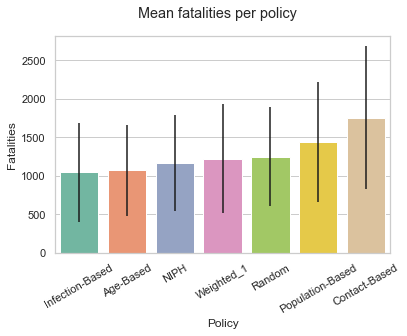

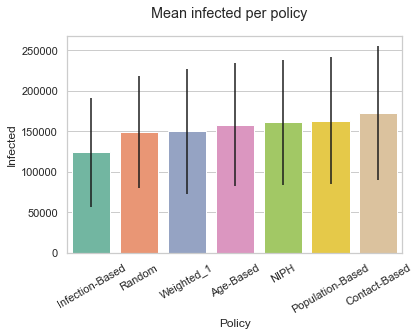

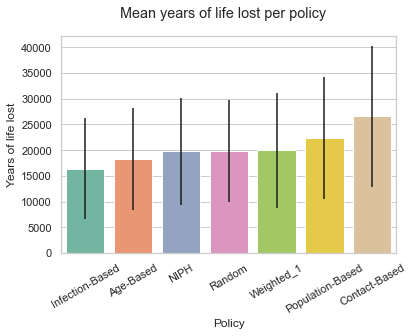

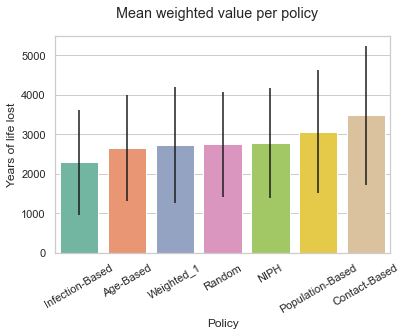

In [26]:
sns.set_theme(style="whitegrid")
keys=list(sorted_dead.keys())
plt.figure()
y=[]
yerr=[]
for key in keys:
    y.append(sorted_dead[key])
    yerr.append(std_dead[key])
sns.barplot(x=keys, y=y, yerr=yerr, palette=colors)
plt.suptitle("Mean fatalities per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Fatalities")

keys=list(sorted_infected.keys())
plt.figure()
y=[]
yerr=[]
for key in keys:
    y.append(sorted_infected[key])
    yerr.append(std_infected[key])
sns.barplot(x=keys, y=y, yerr=yerr, palette=colors)

plt.suptitle("Mean infected per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Infected")

keys=list(sorted_yll.keys())
plt.figure()
y=[]
yerr=[]
for key in keys:
    y.append(sorted_yll[key])
    yerr.append(std_yll[key])
sns.barplot(x=keys, y=y, yerr=yerr, palette=colors)

plt.suptitle("Mean years of life lost per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Years of life lost")


keys=list(sorted_weighted.keys())
plt.figure()
y=[]
yerr=[]
for key in keys:
    y.append(sorted_weighted[key])
    yerr.append(std_weighted[key])
sns.barplot(x=keys, y=y, yerr=yerr, palette=colors)

plt.suptitle("Mean weighted value per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Years of life lost")


In [261]:
print()
print("Dead")
keys = ['Population-Based', "Infection-Based", "Age-Based", "Contact-Based", "NIPH", "Random", "No Vaccines"]

for key in keys:
    print(f"{key:>20} {mean_dead[key]:>8,.0f} {std_dead[key]:>8,.0f} {std_dead[key]/mean_dead[key]:>8,.2f}")
print()
print()
print("Infected")
for key in keys:
    print(f"{key:>20} {mean_infected[key]:>8,.0f} {std_infected[key]:>8,.0f} {std_infected[key]/mean_infected[key]:>8,.2f}")
print()
print()
print("YLL")
for key in keys:
    print(f"{key:>20} {mean_yll[key]:>8,.0f} {std_yll[key]:>8,.0f} {std_yll[key]/mean_yll[key]:>8,.2f}")
print()
print()
print("Vaccinated")
for key in keys:
    print(f"{key:>20} {mean_vaccinated[key]:>8,.0f} {std_vaccinated[key]:>8,.0f} {std_vaccinated[key]/mean_vaccinated[key]:>8,.2f}")

print()
print()
print("Weighted")
for key in keys:
    print(f"{key:>20} {mean_weighted[key]:>8,.0f} {std_weighted[key]:>8,.0f} {std_weighted[key]/mean_weighted[key]:>8,.2f}")


Dead
    Population-Based    1,555      600     0.39
     Infection-Based    1,302      554     0.43
           Age-Based    1,325      533     0.40
       Contact-Based    1,783      671     0.38
                NIPH    1,378      539     0.39
              Random    1,480      550     0.37
         No Vaccines    1,862      684     0.37


Infected
    Population-Based  196,192   63,535     0.32
     Infection-Based  166,210   59,209     0.36
           Age-Based  198,324   64,718     0.33
       Contact-Based  203,631   66,350     0.33
                NIPH  195,778   63,563     0.32
              Random  191,711   59,967     0.31
         No Vaccines  220,212   69,504     0.32


YLL
    Population-Based   24,908    9,282     0.37
     Infection-Based   20,832    8,605     0.41
           Age-Based   22,705    8,762     0.39
       Contact-Based   28,147   10,272     0.36
                NIPH   23,371    8,805     0.38
              Random   24,007    8,594     0.36
         No Vacci

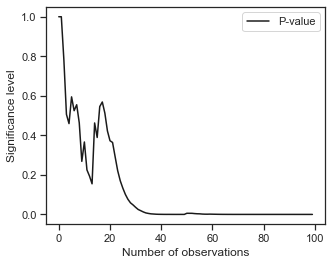

In [390]:
for cut_off in range(88,89):
    objective_value_best = objective_values[list(sorted_dead.keys())[0]][cut_off:cut_off+100,0]
    objective_value_second_best = objective_values[list(sorted_dead.keys())[1]][cut_off:cut_off+100,0]
    p_values = np.zeros(len(objective_value_best))
    observations = np.arange(len(objective_value_best))
    for i in range(len(objective_value_best)-1):
        p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
    p_values[np.isnan(p_values)] = 1
    plt.figure(figsize=(5,4))
    sns.set_style('ticks')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    sns.lineplot(observations, p_values, label="P-value", color='k')
    plt.xlabel("Number of observations")
    plt.ylabel("Significance level")
    plt.savefig("../plots/computational_study/fatalities_significance.png", dpi=200)
    
    plt.show()
    plt.close()

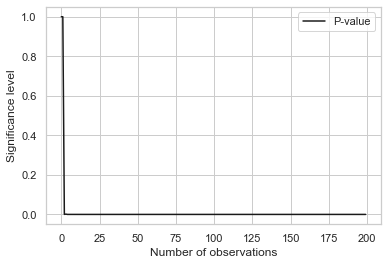

In [345]:
objective_value_best = objective_values[list(sorted_infected.keys())[0]][:200,1]
objective_value_second_best = objective_values[list(sorted_infected.keys())[1]][:200,1]

p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/infected_significance.png", dpi=200)

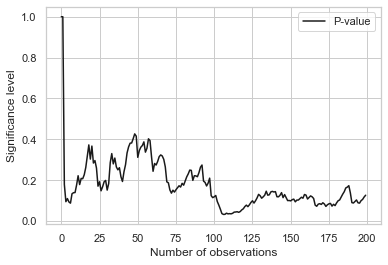

In [148]:
objective_value_best = objective_values[list(sorted_yll.keys())[3]][:200,2]
objective_value_second_best = objective_values[list(sorted_yll.keys())[4]][:200,2]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/yll_significance.png", dpi=200)

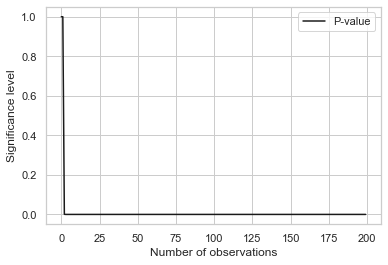

In [149]:
objective_value_best = objective_values[list(sorted_weighted.keys())[0]][:200,4]
objective_value_second_best = objective_values[list(sorted_weighted.keys())[1]][:200,4]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance.png", dpi=200)

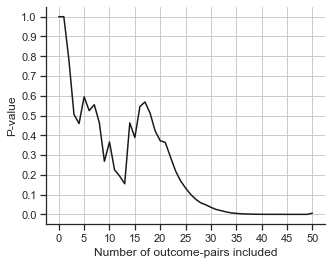

In [406]:
objective_value_best = objective_values[list(sorted_dead.keys())[0]][88:,0]
objective_value_second_best = objective_values[list(sorted_dead.keys())[1]][88:,0]

p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

plt.figure(figsize=(5,4))
sns.set_style('ticks')
ax = sns.lineplot(observations[:51], p_values[:51], color='k')
plt.xticks(observations[0:51:5])
plt.yticks([0.1*i for i in range(11)])
plt.xlabel("Number of outcome-pairs included")
plt.ylabel("P-value")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid()
plt.savefig("../plots/computational_study/fatalities_significance_narrowed.png", dpi=200)

In [378]:
 def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

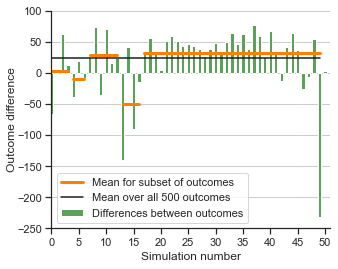

In [423]:
observations = np.arange(len(objective_value_best))
diffs = np.arange(len(objective_value_best))
for i in range( len(objective_value_best)-1):
   diffs[i] = objective_value_second_best[i] - objective_value_best[i]
l1 = 0  #limit 1
l2 = 4  #limit 2
l3 = 7  #limit 3
l4 = 13  #limit 4
l5 = 17  #limit 5
l6 = 50 #limit 6
l7 = 50 #limit 7
plt.figure(figsize=(5,4))
sns.set_style('ticks')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = sns.barplot(observations[:l7+1], diffs[:l7+1], label = "Differences between outcomes", color=colors[2], dodge=False)
change_width(ax,0.6)
sns.lineplot(observations[:l1], np.mean(diffs[:l1]), label = "Mean for subset of simulations", linewidth=2.5, color=colors[4], ax=ax)
sns.lineplot(observations[l1:l2], np.mean(diffs[l1:l2]),label = "Mean for subset of outcomes", linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l2:l3], np.mean(diffs[l2:l3]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l3:l4], np.mean(diffs[l3:l4]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l4:l5], np.mean(diffs[l4:l5]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l5:l6], np.mean(diffs[l5:l6]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l6:l7], np.mean(diffs[l6:l7]),label = "Mean for subset of simulations", linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[:l7], np.mean(diffs[:]), label = f"Mean over all 500 outcomes", linewidth=1.5, color='k', ax=ax)
plt.xticks(observations[:l7+1:5])
plt.xlim(0, 51)
plt.xlabel("Simulation number")
plt.yticks(np.arange(-250,101,step=50))
ax.yaxis.grid()
ax.set_ylabel("Outcome difference", labelpad=0)
sns.set_style('ticks')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("../plots/computational_study/fatalities_diffs.png", dpi=200)

In [409]:
np.mean(diffs[:])

24.067961165048544

In [34]:
print(np.mean(diffs[:l1]))
print(np.mean(diffs[l1:l2]))
print(np.mean(diffs[l2:l3]))
print(np.mean(diffs[l3:l4]))
print(np.mean(diffs[:]))

25.45
-31.5
31.318181818181817
-35.77777777777778
24.964


In [35]:
print(diffs[:100])

[-304   -1  -70   36  -12    7  126   36   72   71  105  -23   65   25
   65   60  100   79  -38  110 -102   51  -11 -139   75  -63   54   56
   54  -79   96  228  108  -78   59  -17   -4   29  -45  -36  134   80
  123   74   64   68   42   53   19 -177   72   50   27   40  -67   89
  113   38 -131 -123  114    3   70   76   44   29   14  -36 -173   11
  -26  -27   85    0   66   58   52   22   80   -4   86   78   68   69
   46 -107   85   29   43   65   83   51 -192   15  -11   64   86 -344
  -27   51]
